# Multimodal Training/Prediction for Image + Text + Tabular

이미지가 포함된 멀티모달 데이터도 한 줄의 코드로 쉽게 훈련 가능합니다. 

In [1]:
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

<br>

## 1. Data preparation and Training

### Load Data
본 핸즈온은 빠른 실습을 위해 PetFinder 데이셋의 일부만 사용합니다. 입양 프로필 정보를 기반으로 애완 동물의 입양 속도를 예측하는 문제로, 문제를 단순화하여 0(느림)/1(빠름) 이진 분류 문제로 변환하였습니다.

클래스 개수 또한, 실생활에서 많이 접하는 불균형 문제가 아닌 300/300(1:1 비율)입니다.

In [2]:
save_path = 'ag-03-multimodal-img-text-tabular'
download_dir = './ag_automm_tutorial'
!rm -rf $save_path $download_dir

In [3]:
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

  0%|          | 0.00/18.8M [00:00<?, ?iB/s]

100%|██████████| 18.8M/18.8M [00:00<00:00, 56.9MiB/s]


In [4]:
import pandas as pd
dataset_path = download_dir + '/petfinder_for_tutorial'
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
label_col = 'AdoptionSpeed'

In [5]:
train_data['AdoptionSpeed'].value_counts()

0    300
1    300
Name: AdoptionSpeed, dtype: int64

각 동물의 입양 프로필에는 사진, 텍스트 설명, 연령, 품종, 이름, 색상 등과 같은 다양한 피쳐가 포함되어 있습니다.

In [6]:
train_data.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Images
0,2,Yumi Hamasaki,4,292,265,2,1,5,7,2,...,1,0,41326,bcc4e1b9557a8b3aaf545ea8e6e86991,0,I rescued Yumi Hamasaki at a food stall far aw...,7d7a39d71,3.0,0,images/7d7a39d71-1.jpg
1,2,Nene/ Kimie,12,285,0,2,5,6,7,2,...,1,0,41326,f0450bf0efe0fa3ff9321d0b827b1237,0,Has adopted by a friend with new pet name Kimie,0e107c82f,3.0,0,images/0e107c82f-1.jpg
2,2,Mattie,12,266,0,2,1,7,0,2,...,1,0,41401,9b52af6d48a4521fd01d4028eb5879a3,0,I rescued Mattie with a broken leg. After surg...,1a8fd6707,5.0,0,images/1a8fd6707-1.jpg
3,1,NaN,1,189,307,2,1,2,0,2,...,1,0,41401,88da1210e021a5cf43480b074778f3bc,0,She born on 30 September . I really hope the a...,bca8b44ae,3.0,0,images/bca8b44ae-1.jpg
4,2,Coco,6,276,285,2,2,4,7,2,...,1,100,41326,227d7b1bcfaffb5f9882bf57b5ee8fab,0,Calico Tame and easy going Diet RC Kitten Supp...,2def67952,1.0,0,images/2def67952-1.jpg


In [7]:
example_row = train_data.iloc[0]
example_row

Type                                                             2
Name                                                 Yumi Hamasaki
Age                                                              4
Breed1                                                         292
Breed2                                                         265
Gender                                                           2
Color1                                                           1
Color2                                                           5
Color3                                                           7
MaturitySize                                                     2
FurLength                                                        2
Vaccinated                                                       1
Dewormed                                                         3
Sterilized                                                       2
Health                                                        

### Modify image path to absolute image path

In [8]:
train_data['Images']

0      images/7d7a39d71-1.jpg
1      images/0e107c82f-1.jpg
2      images/1a8fd6707-1.jpg
3      images/bca8b44ae-1.jpg
4      images/2def67952-1.jpg
                ...          
595    images/aeffc6dfd-1.jpg
596    images/a4f6acdb6-1.jpg
597    images/38063ee14-1.jpg
598    images/d3faf6a0e-1.jpg
599    images/8b0fa13e1-1.jpg
Name: Images, Length: 600, dtype: object

In [9]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])

def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/home/ec2-user/SageMaker/autogluon-on-aws/4.multimodal/ag_automm_tutorial/petfinder_for_tutorial/images/7d7a39d71-1.jpg'

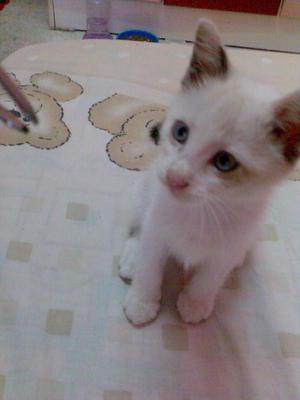

In [10]:
example_row = train_data.iloc[0]
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

<br>

## 2. Training

In [ ]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(label=label_col, path=save_path)
predictor.fit(
    train_data=train_data,
    time_limit=120, # seconds
)

Extension horovod.torch has not been built: /home/ec2-user/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


Global seed set to 123


In [15]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores

Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.9408}

In [ ]:
# predictor.save('my_saved_dir')
# loaded_predictor = MultiModalPredictor.load('my_saved_dir')
# scores2 = loaded_predictor.evaluate(test_data, metrics=["roc_auc"])
# scores2